In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (576/576), done.
instances_val2014.json
loading annotations into memory...
Done (t=7.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
http://images.cocodataset.org/val2014/COCO_val2014_000000080104.jpg
Number of captions for the image: 5
a train on a train track at a train station 
A bunch of people wait as the train approaches the station.
A train is pulling into an empty station,
A busy passenger train station with a train pulling in.
A train is going under a passenger zone area.
train2014 zip removed
test2014 zip removed


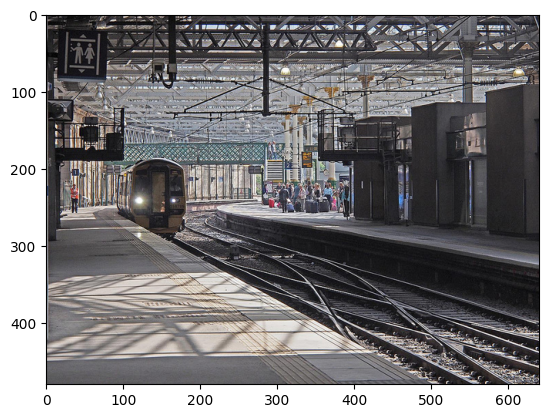

In [ ]:
import os
import urllib.request
import zipfile
from pycocotools.coco import COCO
import numpy as np
import io
from skimage.io import imread
import matplotlib.pyplot as plt

# Create the directory structure and navigate to it
os.makedirs('coco_data', exist_ok=True)
os.chdir('/content/coco_data')
!git clone 'https://github.com/cocodataset/cocoapi.git'
os.chdir('/content/coco_data/cocoapi')

# URLs for downloading COCO annotations
train_val_annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
test_info_annotations_url = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

# Download the annotations
urllib.request.urlretrieve(train_val_annotations_url, 'train_val_annotations.zip')
urllib.request.urlretrieve(test_info_annotations_url, 'test_info_annotations.zip')

# Extract annotation zip files
with zipfile.ZipFile('train_val_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/coco_data/cocoapi')
os.remove('train_val_annotations.zip')

with zipfile.ZipFile('test_info_annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/coco_data/cocoapi')
os.remove('test_info_annotations.zip')

# Navigate to annotations directory and set up COCO API
os.chdir('/content/coco_data/cocoapi/annotations')
dataset_type = 'val2014'
instance_annotations_file = 'instances_{}.json'.format(dataset_type)
caption_annotations_file = 'captions_{}.json'.format(dataset_type)

coco_instance_api = COCO(instance_annotations_file)
coco_caption_api = COCO(caption_annotations_file)

# Retrieve image IDs
image_ids = list(coco_instance_api.anns.keys())

# Select a random annotation ID and display the corresponding image
random_annotation_id = np.random.choice(image_ids)
image_id = coco_instance_api.anns[random_annotation_id]['image_id']
image_details = coco_instance_api.loadImgs(image_id)[0]
image_url = image_details['coco_url']
print(image_url)
image_data = imread(image_url)
plt.imshow(image_data)

# Display captions for the selected image
caption_ids = coco_caption_api.getAnnIds(imgIds=image_id)
print('Number of captions for the image:', len(caption_ids))
captions = coco_caption_api.loadAnns(caption_ids)
coco_caption_api.showAnns(captions)

# Download and extract image datasets
os.chdir('/content/coco_data/cocoapi')
datasets_urls = {
    'train2014': 'http://images.cocodataset.org/zips/train2014.zip',
    'test2014': 'http://images.cocodataset.org/zips/test2014.zip'
}

for dataset_name, dataset_url in datasets_urls.items():
    urllib.request.urlretrieve(dataset_url, f"{dataset_name}.zip")
    with zipfile.ZipFile(f"{dataset_name}.zip", 'r') as zip_ref:
        zip_ref.extractall('images')
    os.remove(f"{dataset_name}.zip")
    print(f"{dataset_name} zip removed")


In [ ]:
# vocabulary.py -----------------------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):
    def __init__(self, vocab_threshold, vocab_file='./vocab.pkl', start_word="<start>", end_word="<end>",
                 unk_word="<unk>", annotations_file='/content/coco_data/cocoapi/annotations/captions_train2014.json',
                 vocab_from_file=False):
        """Initialize the vocabulary."""
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load or build the vocabulary."""
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary loaded from file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
            print('Vocabulary built and saved to file.')

    def build_vocab(self):
        """Build the vocabulary."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the vocabulary mappings."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a word to the vocabulary."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Add words from captions to the vocabulary."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print(f"[{i}/{len(ids)}] Tokenizing captions...")

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]
        for word in words:
            self.add_word(word)

    def __call__(self, word):
        """Retrieve a word's index in the vocabulary; return unk index if not found."""
        return self.word2idx.get(word, self.word2idx[self.unk_word])

    def __len__(self):
        """Return the size of the vocabulary."""
        return len(self.word2idx)

import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform, mode='train', batch_size=1, vocab_threshold=None, vocab_file='./vocab.pkl',
               start_word="<start>", end_word="<end>", unk_word="<unk>", vocab_from_file=True,
               num_workers=0, cocoapi_loc='/content/coco_data'):
    """Return the data loader."""
    assert mode in ['train', 'test'], "mode must be 'train' or 'test'."
    if vocab_from_file == False: assert mode == 'train', "To generate vocab, must be in training mode."

    img_folder = os.path.join(cocoapi_loc, f'cocoapi/images/{mode}2014/')
    annotations_file = os.path.join(cocoapi_loc, f'cocoapi/annotations/captions_{mode}2014.json') if mode == 'train' else os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    dataset = CoCoDataset(transform=transform, mode=mode, batch_size=batch_size, vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file, start_word=start_word, end_word=end_word, unk_word=unk_word,
                          annotations_file=annotations_file, vocab_from_file=vocab_from_file, img_folder=img_folder)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size, drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset, batch_size=dataset.batch_size, shuffle=True, num_workers=num_workers)

    return data_loader



In [ ]:
import requests
import os
from io import BytesIO
from PIL import Image
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
from pycocotools.coco import COCO


os.chdir('/content/coco_data/cocoapi/annotations')
dataType = 'val2014'
instances_annFile = f'instances_{dataType}.json'
captions_annFile = f'captions_{dataType}.json'

# Initialize COCO API with updated paths
coco_instances = COCO(instances_annFile)
coco_captions = COCO(captions_annFile)

# Initialize models and pipelines
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
gpt2_caption_pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
pix2struct_caption_pipeline = pipeline("image-to-text", model="google/pix2struct-textcaps-base")

# Function to generate captions using BLIP, GPT-2, and Pix2Struct
def generate_captions(image):
    # BLIP
    blip_inputs = blip_processor(images=image, return_tensors="pt")
    blip_outputs = blip_model.generate(**blip_inputs)
    blip_caption = blip_processor.decode(blip_outputs[0], skip_special_tokens=True)

    # GPT-2
    gpt2_caption = gpt2_caption_pipeline(image)[0]['generated_text']

    # Pix2Struct
    pix2struct_caption = pix2struct_caption_pipeline(image)[0]['generated_text']

    return blip_caption, gpt2_caption, pix2struct_caption

# Process images and generate captions
selected_ann_ids = list(coco_instances.anns.keys())[1001:1100]  # Adjust the range as needed
captions_data = []

image_counter = 0  # To track the iteration number
for ann_id in selected_ann_ids:
    img_id = coco_instances.anns[ann_id]['image_id']
    img = coco_instances.loadImgs(img_id)[0]
    url = img['coco_url']
    image_counter += 1
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))

        # Generate captions
        blip_caption, gpt2_caption, pix2struct_caption = generate_captions(image)

        # Fetch original COCO captions
        ann_ids = coco_captions.getAnnIds(imgIds=img_id)
        anns = coco_captions.loadAnns(ann_ids)
        original_captions = [ann['caption'] for ann in anns]

        print(blip_caption,gpt2_caption, pix2struct_caption)
        # Store captions
        captions_data.append({
            'image_id': img_id,
            'url': url,
            'generated_captions': {
                'blip': blip_caption,
                'gpt2': gpt2_caption,
                'pix2struct': pix2struct_caption
            },
            'original_coco_captions': original_captions
        })
    except Exception as e:
        print(f"Failed to process image ID {img_id}: {e}")


loading annotations into memory...
Done (t=16.06s)
creating index...
index created!
loading annotations into memory...
Done (t=1.61s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/217 [00:00<?, ?B/s]

0


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


a kitchen with a stove and sink in it a kitchen with a stove, sink, and a refrigerator  A computer monitor with a screen that says '12:12'
1
a man taking a picture of himself in a bathroom a man in a bathroom brushing his teeth  A man wearing a red shirt that says Nivas on it.
2


KeyboardInterrupt: 

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline

# Initialize BLIP model and processor
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Initialize GPT-2 caption pipeline
gpt2_caption_pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

# Initialize summarization pipeline
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to calculate total parameters for a Transformers model
def get_total_params_transformer(model):
    return sum(p.numel() for p in model.parameters())

# Calculate total parameters for BLIP
total_params_blip = get_total_params_transformer(blip_model)

# For pipelines, access the underlying model to calculate parameters
total_params_gpt2 = get_total_params_transformer(gpt2_caption_pipeline.model)
total_params_summarizer = get_total_params_transformer(summarizer.model)

print(total_params_blip)
print(total_params_gpt2)
print(total_params_summarizer)

# Summing up all parameters
total_parameters = total_params_blip + total_params_gpt2 + total_params_summarizer

print(f"Total number of parameters across all models: {total_parameters}")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


247414076
239195904
305510400
Total number of parameters across all models: 792120380


In [ ]:
import time
import requests
from transformers import pipeline
from PIL import Image
from io import BytesIO
from transformers import BlipProcessor, BlipForConditionalGeneration

# Initialize models and pipelines
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
gpt2_caption_pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def generate_captions(image):
    # Measure BLIP caption generation
    start_blip = time.time()
    blip_inputs = blip_processor(images=image, return_tensors="pt")
    blip_outputs = blip_model.generate(**blip_inputs)
    blip_caption = blip_processor.decode(blip_outputs[0], skip_special_tokens=True)
    end_blip = time.time()
    blip_time = end_blip - start_blip

    # Measure GPT-2 caption generation
    start_gpt2 = time.time()
    gpt2_caption = gpt2_caption_pipeline(image)[0]['generated_text']
    end_gpt2 = time.time()
    gpt2_time = end_gpt2 - start_gpt2

    return blip_caption, gpt2_caption, blip_time, gpt2_time

def summarize_captions(captions):
    start_summary = time.time()
    summaries = []
    for caption in captions:
        summary = summarizer(caption, max_length=45, min_length=5, truncation=True)
        summaries.append(summary[0]['summary_text'])  # Assuming the first summary is the best
    end_summary = time.time()
    summary_time = end_summary - start_summary
    return summaries, summary_time

def process_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Generate captions and measure times
    blip_caption, gpt2_caption, blip_time, gpt2_time = generate_captions(image)

    # Summarize captions and measure summarization time
    all_captions = [blip_caption, gpt2_caption]
    summaries, summary_time = summarize_captions(all_captions)

    # Compile results
    results = {
        "summaries": summaries,
        "times": {
            "blip_time": blip_time,
            "gpt2_time": gpt2_time,
            "summary_time": summary_time
        }
    }
    return results

# Specify the URL of the image
url = "http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg"
results = process_image(url)
print(f"Summaries: {results['summaries']}")
print(f"Caption Generation Time - BLIP: {results['times']['blip_time']}s, GPT-2: {results['times']['gpt2_time']}s")
print(f"Summarization Time: {results['times']['summary_time']}s")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Your max_length is set to 45, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 45, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Summaries: [' a man riding a motorcycle down a dirt road in rural America . a man on a motorcycle was riding a motorcyclist down the dirt road . The incident occurred on the same dirt road as the previous incident .', ' a man riding a motorcycle on a dirt road is seen riding on dirt road . The incident happened in the early hours of the day .']
Caption Generation Time - BLIP: 6.873045206069946s, GPT-2: 3.839010000228882s
Summarization Time: 13.355616092681885s
